In [ ]:
import zipfile
import os
import pandas as pd
import matplotlib.pyplot as plt
import shutil
from sklearn.model_selection import train_test_split
from itertools import zip_longest
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import torch.nn.functional as F
from tqdm import tqdm
import sys
from sklearn.mixture import GaussianMixture
import numpy as np
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Task 1

## Dataset extraction

In [ ]:
zip_path = "/content/aait-asg-2-task-1.zip"
extract_path = "/content/data"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
print(len(os.listdir('/content/data/task1/train_data/images/labeled')))
print(len(os.listdir('/content/data/task1/train_data/images/unlabeled')))
print(len(os.listdir('/content/data/task1/val_data')))

NameError: name 'os' is not defined

In [ ]:
annotations_file = "/content/data/task1/train_data/annotations.csv"

annotations = pd.read_csv(annotations_file)

print(f"Total number of entries in the annotations file: {len(annotations)}")

annotations.head()


Total number of entries in the annotations file: 23555


,sample,label
0,task1/train_data/images/labeled/0.jpeg,0
1,task1/train_data/images/labeled/1.jpeg,1
2,task1/train_data/images/labeled/2.jpeg,2
3,task1/train_data/images/labeled/3.jpeg,3
4,task1/train_data/images/labeled/4.jpeg,4


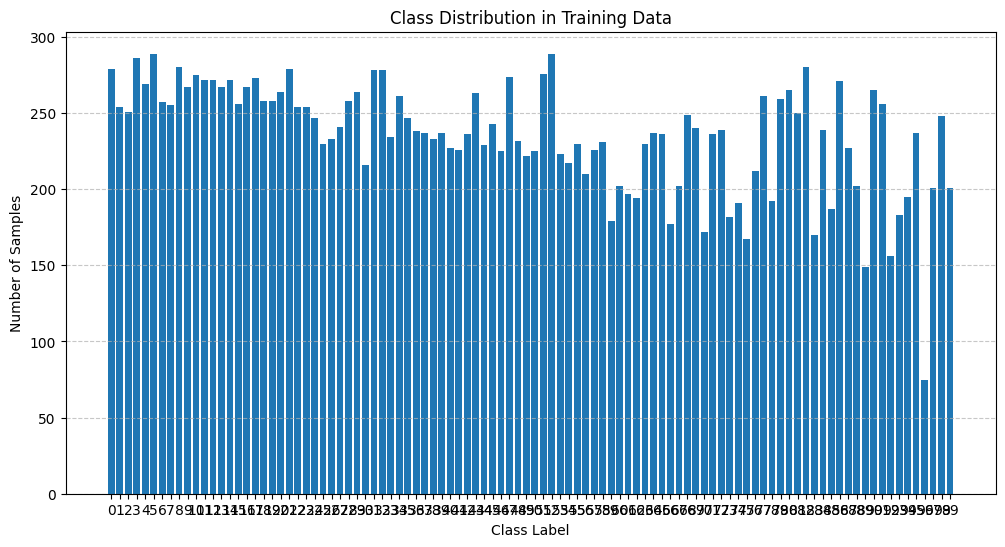

In [ ]:
class_counts = annotations['label'].value_counts().sort_index()

# Plot class distribution
plt.figure(figsize=(12, 6))
plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Class Label')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Training Data')
plt.xticks(range(len(class_counts)))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Full supervised learning

In [ ]:
annotations_path = "/content/data/task1/train_data/annotations.csv"
labeled_images_path = "/content/data/task1/train_data/images/labeled"
unlabeled_images_path = "/content/data/task1/train_data/images/unlabeled"
val_images_path = "/content/data/task1/val_data"

# Load annotations
annotations = pd.read_csv(annotations_path)
# Split into train and val
train_annotations, val_annotations = train_test_split(annotations, test_size=0.2, stratify=annotations['label'], random_state=42)

print(f"Training samples: {len(train_annotations)}, Validation samples: {len(val_annotations)}")

Training samples: 18844, Validation samples: 4711


In [ ]:
class LabeledDataset(Dataset):
    def __init__(self, annotations, image_dir, transform=None):
        self.annotations = annotations
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_name = self.annotations.iloc[idx, 0]
        label = self.annotations.iloc[idx, 1]
        img_path = os.path.join(self.image_dir, img_name)

        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        return image, label


class UnlabeledDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.images = sorted(os.listdir(image_dir))
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)

        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        return image, img_name

In [ ]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


train_dataset = LabeledDataset(train_annotations, "/content/data", transform=train_transforms)
val_dataset = LabeledDataset(val_annotations, "/content/data", transform=val_transforms)

# Create DataLoaders
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Training batches: {len(train_loader)}, Validation batches: {len(val_loader)}")

Training batches: 589, Validation batches: 148


In [ ]:
model = models.resnet50(weights="DEFAULT")
num_classes = len(annotations['label'].unique())
model.fc = nn.Linear(model.fc.in_features, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=0.001)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 198MB/s]


In [ ]:
# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    # Training on labeled data
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100.0 * correct / total

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = 100.0 * val_correct / val_total

    print(f"Epoch {epoch + 1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")


Epoch 1/10, Train Loss: 3.8079, Train Acc: 12.37%, Val Loss: 3.6270, Val Acc: 16.64%
Epoch 2/10, Train Loss: 3.2504, Train Acc: 22.19%, Val Loss: 2.8999, Val Acc: 29.44%
Epoch 3/10, Train Loss: 2.9479, Train Acc: 27.76%, Val Loss: 2.6354, Val Acc: 35.13%
Epoch 4/10, Train Loss: 2.7325, Train Acc: 32.45%, Val Loss: 2.4632, Val Acc: 37.95%
Epoch 5/10, Train Loss: 2.5700, Train Acc: 36.32%, Val Loss: 2.2980, Val Acc: 40.88%
Epoch 6/10, Train Loss: 2.4144, Train Acc: 39.41%, Val Loss: 2.2994, Val Acc: 41.90%
Epoch 7/10, Train Loss: 2.2987, Train Acc: 41.90%, Val Loss: 2.2302, Val Acc: 43.60%
Epoch 8/10, Train Loss: 2.1753, Train Acc: 44.41%, Val Loss: 2.0881, Val Acc: 47.57%
Epoch 9/10, Train Loss: 2.0837, Train Acc: 46.29%, Val Loss: 2.0556, Val Acc: 48.52%
Epoch 10/10, Train Loss: 1.9841, Train Acc: 49.16%, Val Loss: 1.9812, Val Acc: 50.22%


In [ ]:
torch.save(model.state_dict(), "10_model.pth")


In [ ]:
# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    # Training on labeled data
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100.0 * correct / total

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = 100.0 * val_correct / val_total

    print(f"Epoch {epoch + 1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")


Epoch 1/10, Train Loss: 1.8902, Train Acc: 51.05%, Val Loss: 1.9930, Val Acc: 50.84%
Epoch 2/10, Train Loss: 1.7969, Train Acc: 53.38%, Val Loss: 1.9531, Val Acc: 51.69%
Epoch 3/10, Train Loss: 1.7387, Train Acc: 54.37%, Val Loss: 1.9244, Val Acc: 53.13%
Epoch 4/10, Train Loss: 1.6576, Train Acc: 56.68%, Val Loss: 2.0039, Val Acc: 53.22%
Epoch 5/10, Train Loss: 1.5750, Train Acc: 58.59%, Val Loss: 1.8960, Val Acc: 54.00%
Epoch 6/10, Train Loss: 1.5017, Train Acc: 60.23%, Val Loss: 2.0430, Val Acc: 52.54%
Epoch 7/10, Train Loss: 1.4375, Train Acc: 61.88%, Val Loss: 2.0566, Val Acc: 51.31%
Epoch 8/10, Train Loss: 1.3772, Train Acc: 63.30%, Val Loss: 1.9268, Val Acc: 54.53%
Epoch 9/10, Train Loss: 1.3121, Train Acc: 65.20%, Val Loss: 2.1435, Val Acc: 52.22%
Epoch 10/10, Train Loss: 1.2517, Train Acc: 66.40%, Val Loss: 2.0115, Val Acc: 54.40%


In [ ]:
torch.save(model.state_dict(), "20_model.pth")

In [ ]:
val_dir = "/content/data/task1/val_data"

# Create the validation dataset and DataLoader
test_dataset = UnlabeledDataset(val_dir, transform=val_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


all_files = sorted(os.listdir(val_dir))

# Check for duplicates
duplicates = set([file for file in all_files if all_files.count(file) > 1])
if duplicates:
    print(f"Duplicate files found: {duplicates}")
else:
    print("No duplicates in val_data.")

No duplicates in val_data.


In [ ]:
model.eval()

# List to store predictions
predictions = []

# Inference loop
with torch.no_grad():
    for images, img_names in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)  # Get the index of the max log-probability

        # Append predictions with image names
        for img_name, label in zip(img_names, predicted.cpu().numpy()):
            predictions.append({
                "ID": f"task1/val_data/{img_name}",
                "label": label
            })

# Convert predictions to a DataFrame
submission_df = pd.DataFrame(predictions)

# Save to CSV
submission_file = "submission.csv"
submission_df.to_csv(submission_file, index=False)

print(f"Submission file saved as {submission_file}")

Submission file saved as submission.csv


In [ ]:
# Check for duplicate IDs
if submission_df["ID"].duplicated().any():
    print("Duplicate IDs found in submission file!")
    duplicates = submission_df[submission_df["ID"].duplicated(keep=False)]
    print(duplicates)
else:
    print("No duplicate IDs in submission file.")

No duplicate IDs in submission file.


## FixMatch

In [ ]:
# Custom Dataset for Labeled Data
class LabeledDataset(Dataset):
    def __init__(self, annotations_df, image_dir, transform=None):
        self.annotations_df = annotations_df
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations_df)

    def __getitem__(self, idx):
        img_name = self.annotations_df.iloc[idx, 0]
        label = self.annotations_df.iloc[idx, 1]
        img_path = os.path.join(self.image_dir, img_name)

        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        return image, label

# Custom Dataset for Unlabeled Data
class UnlabeledDataset(Dataset):
    def __init__(self, image_dir, weak_transform=None, strong_transform=None):
        self.image_dir = image_dir
        self.image_files = sorted(os.listdir(image_dir))
        self.weak_transform = weak_transform
        self.strong_transform = strong_transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)

        image = Image.open(img_path).convert("RGB")
        weak_image = self.weak_transform(image) if self.weak_transform else image
        strong_image = self.strong_transform(image) if self.strong_transform else image

        return weak_image, strong_image, img_name

In [ ]:
def fixmatch_loss(weak_logits, strong_logits, threshold=0.80):
    """
    Consistency regularization loss for FixMatch.
    Args:
        weak_logits: Logits from weakly augmented images.
        strong_logits: Logits from strongly augmented images.
        threshold: Confidence threshold for pseudo-labeling.
    Returns:
        Consistency loss for unlabeled data.
    """


    probs = F.softmax(weak_logits, dim=1)
    pseudo_labels = torch.argmax(probs, dim=1)
    mask = probs.max(dim=1)[0] >= threshold  # Confidence mask

    # # Debugging output
    # print(f"Mask sum: {mask.sum().item()}, Total samples: {mask.size(0)}")
    # print(f"Probabilities max: {probs.max(dim=1)[0]}")

    if mask.sum().item() == 0:  # No samples meet the confidence threshold
        return torch.tensor(0.0, requires_grad=True).to(weak_logits.device)

    return F.cross_entropy(strong_logits[mask], pseudo_labels[mask])

In [ ]:
# Weak augmentation (basic resizing and flipping)
weak_augment = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Strong augmentation (color jitter, random crop, etc.)
strong_augment = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Augmentation for labeled data
train_augment = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])



# Load labeled data
annotations_path = "/content/data/task1/train_data/annotations.csv"
annotations_df = pd.read_csv(annotations_path)

labeled_dataset = LabeledDataset(annotations_df, "/content/data", transform=train_augment)
labeled_loader = DataLoader(labeled_dataset, batch_size=32, shuffle=True)

# Load unlabeled data
unlabeled_images_dir = "/content/data/task1/train_data/images/unlabeled"
unlabeled_dataset = UnlabeledDataset(unlabeled_images_dir, weak_transform=weak_augment, strong_transform=strong_augment)
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=32, shuffle=True)


In [ ]:
checkpoint_path = "/content/10_model.pth"

model = models.resnet50(weights=None)  # Use pretrained=False since you've trained it already
num_classes = len(annotations_df['label'].unique())
model.fc = nn.Linear(model.fc.in_features, num_classes)

print(num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

model.load_state_dict(torch.load(checkpoint_path))
print("Checkpoint loaded successfully!")

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=0.001)

100
Checkpoint loaded successfully!


<ipython-input-12-1bf1a1b0b297>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))


In [ ]:
num_epochs = 10
lambda_u_schedule = lambda epoch: min(0.5, epoch / 10)  # Full weight of 0.5 after 10 epochs

initial_threshold = 0.70
final_threshold = 0.95
threshold_schedule = lambda epoch: initial_threshold + (final_threshold - initial_threshold) * (epoch / num_epochs)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)


for epoch in range(num_epochs):
    model.train()
    total_loss, supervised_loss, unsupervised_loss = 0, 0, 0
    lambda_u = lambda_u_schedule(epoch)
    threshold = threshold_schedule(epoch)


    for (labeled_batch, unlabeled_batch) in zip_longest(labeled_loader, unlabeled_loader, fillvalue=None):
        if labeled_batch is None or unlabeled_batch is None:
          continue  # Skip incomplete batches

        labeled_imgs, labeled_labels = labeled_batch
        weak_imgs, strong_imgs, _ = unlabeled_batch
        # Labeled data
        labeled_imgs, labeled_labels = labeled_imgs.to(device), labeled_labels.to(device)
        labeled_logits = model(labeled_imgs)
        loss_supervised = criterion(labeled_logits, labeled_labels)

        # Unlabeled data
        weak_imgs, strong_imgs = weak_imgs.to(device), strong_imgs.to(device)
        weak_logits = model(weak_imgs)
        strong_logits = model(strong_imgs)
        loss_unsupervised = fixmatch_loss(weak_logits, strong_logits, threshold=threshold)

        # Combine losses
        loss = loss_supervised + lambda_u * loss_unsupervised

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        supervised_loss += loss_supervised.item()
        unsupervised_loss += loss_unsupervised.item()

    scheduler.step()
    print(f"Epoch {epoch + 1}/{num_epochs}, Lambda_u: {lambda_u:.2f}, Threshold: {threshold:.2f}, "
          f"Total Loss: {total_loss:.4f}, Supervised Loss: {supervised_loss:.4f}, Unsupervised Loss: {unsupervised_loss:.4f}")

Epoch 1/10, Lambda_u: 0.00, Threshold: 0.70, Total Loss: 1491.0569, Supervised Loss: 1491.0569, Unsupervised Loss: 566.5266
Epoch 2/10, Lambda_u: 0.10, Threshold: 0.72, Total Loss: 1447.7164, Supervised Loss: 1392.4243, Unsupervised Loss: 552.9207
Epoch 3/10, Lambda_u: 0.20, Threshold: 0.75, Total Loss: 1413.2791, Supervised Loss: 1307.5684, Unsupervised Loss: 528.5531
Epoch 4/10, Lambda_u: 0.30, Threshold: 0.77, Total Loss: 1376.9800, Supervised Loss: 1226.8890, Unsupervised Loss: 500.3034
Epoch 5/10, Lambda_u: 0.40, Threshold: 0.80, Total Loss: 1318.3026, Supervised Loss: 1124.4493, Unsupervised Loss: 484.6333
Epoch 6/10, Lambda_u: 0.50, Threshold: 0.82, Total Loss: 1256.2495, Supervised Loss: 1024.2525, Unsupervised Loss: 463.9939
Epoch 7/10, Lambda_u: 0.50, Threshold: 0.85, Total Loss: 1144.6912, Supervised Loss: 934.5553, Unsupervised Loss: 420.2719
Epoch 8/10, Lambda_u: 0.50, Threshold: 0.88, Total Loss: 1036.7149, Supervised Loss: 840.0357, Unsupervised Loss: 393.3585
Epoch 9/10

In [ ]:
torch.save(model.state_dict(), "fix10_model.pth")

In [ ]:
additional_epochs = 5
total_epochs = 10 + additional_epochs

lambda_u_schedule = lambda epoch: min(0.5, epoch / total_epochs)
threshold_schedule = lambda epoch: initial_threshold + (final_threshold - initial_threshold) * (epoch / total_epochs)

# Resume training
for epoch in range(10, 15):  # Start from epoch 11
    model.train()
    total_loss, supervised_loss, unsupervised_loss = 0, 0, 0
    lambda_u = lambda_u_schedule(epoch)
    threshold = threshold_schedule(epoch)

    for (labeled_batch, unlabeled_batch) in zip_longest(labeled_loader, unlabeled_loader, fillvalue=None):
        if labeled_batch is None or unlabeled_batch is None:
            continue  # Skip incomplete batches

        # Prepare data
        labeled_imgs, labeled_labels = labeled_batch
        weak_imgs, strong_imgs, _ = unlabeled_batch

        # Labeled data
        labeled_imgs, labeled_labels = labeled_imgs.to(device), labeled_labels.to(device)
        labeled_logits = model(labeled_imgs)
        loss_supervised = criterion(labeled_logits, labeled_labels)

        # Unlabeled data
        weak_imgs, strong_imgs = weak_imgs.to(device), strong_imgs.to(device)
        weak_logits = model(weak_imgs)
        strong_logits = model(strong_imgs)
        loss_unsupervised = fixmatch_loss(weak_logits, strong_logits, threshold=threshold)

        # Combine losses
        loss = loss_supervised + lambda_u * loss_unsupervised

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate losses
        total_loss += loss.item()
        supervised_loss += loss_supervised.item()
        unsupervised_loss += loss_unsupervised.item()

    # Scheduler step
    scheduler.step()

    # Print epoch results
    print(f"Epoch {epoch + 1}/{total_epochs}, Lambda_u: {lambda_u:.2f}, Threshold: {threshold:.2f}, "
          f"Total Loss: {total_loss:.4f}, Supervised Loss: {supervised_loss:.4f}, Unsupervised Loss: {unsupervised_loss:.4f}")


Epoch 11/15, Lambda_u: 0.50, Threshold: 0.87, Total Loss: 921.4260, Supervised Loss: 732.5806, Unsupervised Loss: 377.6909
Epoch 12/15, Lambda_u: 0.50, Threshold: 0.88, Total Loss: 927.2337, Supervised Loss: 737.8690, Unsupervised Loss: 378.7294
Epoch 13/15, Lambda_u: 0.50, Threshold: 0.90, Total Loss: 934.3778, Supervised Loss: 752.5072, Unsupervised Loss: 363.7412
Epoch 14/15, Lambda_u: 0.50, Threshold: 0.92, Total Loss: 939.7047, Supervised Loss: 770.6996, Unsupervised Loss: 338.0103
Epoch 15/15, Lambda_u: 0.50, Threshold: 0.93, Total Loss: 958.8840, Supervised Loss: 786.6824, Unsupervised Loss: 344.4033


In [ ]:
# Define the path to the validation directory
val_dir = "/content/data/task1/val_data"

# Define transformations (same as weak augmentations used during training)
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Custom Dataset for Validation Data
class ValDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_files = sorted(os.listdir(image_dir))
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, img_name

# Create the validation dataset and dataloader
val_dataset = ValDataset(val_dir, transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Load the trained model
model = models.resnet50(weights=None)  # Initialize model
num_classes = len(annotations_df['label'].unique())  # Use the correct number of classes
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
model.load_state_dict(torch.load("/content/fix10_model.pth"))  # Load checkpoint
model = model.to(device)
model.eval()

# Generate predictions
predictions = []

with torch.no_grad():
    for images, img_names in val_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)  # Get class predictions

        # Collect predictions with filenames
        for img_name, label in zip(img_names, predicted.cpu().numpy()):
            predictions.append({"ID": f"task1/val_data/{img_name}", "label": label})

# Save predictions to a CSV file
submission_df = pd.DataFrame(predictions)
submission_file = "submission.csv"
submission_df.to_csv(submission_file, index=False)
print(f"Predictions saved to {submission_file}")

<ipython-input-16-4d013016cee3>:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/fix10_model.pth"))  # Load checkpoint


Predictions saved to submission.csv


## ViT

In [ ]:
from transformers import ViTForImageClassification, ViTImageProcessor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model and feature extractor
model_name = "google/vit-base-patch16-224-in21k"
model = ViTForImageClassification.from_pretrained(model_name, num_labels=100)  # Adjust num_labels as needed
model = model.to(device)


feature_extractor = ViTImageProcessor.from_pretrained(model_name)

# Define transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std),
])

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Custom dataset class
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, annotations_df, image_dir, transform=None):
        self.annotations_df = annotations_df
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations_df)

    def __getitem__(self, idx):
        img_name = self.annotations_df.iloc[idx, 0]
        label = self.annotations_df.iloc[idx, 1]
        img_path = os.path.join(self.image_dir, img_name)

        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        return image, label


In [ ]:
save_dir = "./checkpoints/"
os.makedirs(save_dir, exist_ok=True)

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std),
])
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std),
])


annotations_file = "/content/data/task1/train_data/annotations.csv"

annotations_df = pd.read_csv(annotations_file)

# Stratified split (preserves class distribution)
train_annotations, val_annotations = train_test_split(annotations_df, test_size=0.2, stratify=annotations_df['label'], random_state=42)

train_dataset = CustomDataset(train_annotations, "/content/data", transform=train_transform)
val_dataset = CustomDataset(val_annotations, "/content/data", transform=val_transform)

# Optimizer and Scheduler
optimizer = optim.AdamW(model.parameters(), lr=5e-5)

scheduler = StepLR(optimizer, step_size=3, gamma=0.1)


criterion = torch.nn.CrossEntropyLoss()


# Create DataLoaders
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Training batches: {len(train_loader)}, Validation batches: {len(val_loader)}")

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.logits.max(1)  # Access logits
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100.0 * correct / total

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs.logits, labels)  # Use logits for validation
            val_loss += loss.item()
            _, predicted = outputs.logits.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = 100.0 * val_correct / val_total

    # Update the scheduler
    scheduler.step()

    # Print epoch metrics
    current_lr = optimizer.param_groups[0]['lr']

    checkpoint_path = os.path.join(save_dir, f"vit_epoch_{epoch + 1}.pth")
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'train_loss': train_loss,
        'val_loss': val_loss,
        'train_acc': train_acc,
        'val_acc': val_acc,
    }, checkpoint_path)

    print(f"Epoch {epoch + 1}/{num_epochs}, "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, LR: {current_lr:.2e}")

Training batches: 589, Validation batches: 148
Epoch 1/10, Train Loss: 1.6836, Train Acc: 76.39%, Val Loss: 0.8562, Val Acc: 89.37%, LR: 5.00e-05
Epoch 2/10, Train Loss: 1.0386, Train Acc: 80.57%, Val Loss: 0.5558, Val Acc: 89.66%, LR: 5.00e-05
Epoch 3/10, Train Loss: 0.8185, Train Acc: 82.68%, Val Loss: 0.4614, Val Acc: 90.38%, LR: 5.00e-06
Epoch 4/10, Train Loss: 0.6486, Train Acc: 86.17%, Val Loss: 0.4067, Val Acc: 91.51%, LR: 5.00e-06
Epoch 5/10, Train Loss: 0.6001, Train Acc: 87.50%, Val Loss: 0.3934, Val Acc: 91.85%, LR: 5.00e-06
Epoch 6/10, Train Loss: 0.5825, Train Acc: 87.59%, Val Loss: 0.3865, Val Acc: 92.10%, LR: 5.00e-07
Epoch 7/10, Train Loss: 0.5607, Train Acc: 88.07%, Val Loss: 0.3843, Val Acc: 92.10%, LR: 5.00e-07
Epoch 8/10, Train Loss: 0.5490, Train Acc: 88.21%, Val Loss: 0.3829, Val Acc: 92.04%, LR: 5.00e-07
Epoch 9/10, Train Loss: 0.5579, Train Acc: 88.23%, Val Loss: 0.3821, Val Acc: 92.15%, LR: 5.00e-08
Epoch 10/10, Train Loss: 0.5521, Train Acc: 88.33%, Val Loss: 

In [ ]:
torch.save(model.state_dict(), "vit_labeled_model.pth")

In [ ]:
# Define test transforms
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224 pixels
    transforms.ToTensor(),         # Convert the image to a PyTorch tensor
    transforms.Normalize(
        mean=feature_extractor.image_mean,  # Normalize using the mean of the pre-trained model
        std=feature_extractor.image_std    # Normalize using the std of the pre-trained model
    ),
])
# Custom Dataset for Validation Data
class ValDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_files = sorted(os.listdir(image_dir))
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, img_name

# Create validation dataset and dataloader
val_dir = "/content/data/task1/val_data"
val_dataset = ValDataset(val_dir, transform=test_transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f"Validation dataset loaded: {len(val_dataset)} images.")

model.eval()
# Generate predictions
predictions = []

with torch.no_grad():
    for images, img_names in val_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = outputs.logits.max(1)  # Get predicted labels

        # Append predictions with filenames
        for img_name, label in zip(img_names, predicted.cpu().numpy()):
            predictions.append({"ID": f"task1/val_data/{img_name}", "label": label})

# Save predictions to a CSV file
submission_df = pd.DataFrame(predictions)
submission_file = "submission.csv"
submission_df.to_csv(submission_file, index=False)
print(f"Predictions saved to {submission_file}")

Validation dataset loaded: 5000 images.
Predictions saved to submission.csv


## Fixmatch VIT

In [ ]:
from transformers import ViTForImageClassification, ViTFeatureExtractor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the model name and number of labels
model_name = "google/vit-base-patch16-224-in21k"  # Replace with your model name if different
num_labels = 100  # Adjust based on your dataset

# Initialize the model
model = ViTForImageClassification.from_pretrained(model_name, num_labels=num_labels)
model.load_state_dict(torch.load("vit_labeled_model.pth"))  # Replace with the path to your saved model
model = model.to(device)

print("ViT model trained on labeled data loaded successfully!")

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-18-df1b047870d8>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_glob

ViT model trained on labeled data loaded successfully!


In [ ]:
# Define FixMatch loss
def fixmatch_loss(weak_logits, strong_logits, threshold=0.95):
    probs = F.softmax(weak_logits, dim=1)
    pseudo_labels = torch.argmax(probs, dim=1)
    mask = probs.max(dim=1)[0] >= threshold  # Confidence mask
    if mask.sum() == 0:  # Handle cases with no confident pseudo-labels
        return torch.tensor(0.0, requires_grad=True).to(weak_logits.device)
    return F.cross_entropy(strong_logits[mask], pseudo_labels[mask])

In [ ]:
# Feature extractor for normalization
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)

# Define augmentations
# Weak augmentation
weak_augment = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std),
])

# Strong augmentation
strong_augment = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(224),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std),
])

# Define datasets
class LabeledDataset(Dataset):
    def __init__(self, annotations_df, image_dir, transform=None):
        self.annotations_df = annotations_df
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations_df)

    def __getitem__(self, idx):
        img_name = self.annotations_df.iloc[idx, 0]
        label = self.annotations_df.iloc[idx, 1]
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

class UnlabeledDataset(Dataset):
    def __init__(self, image_dir, weak_transform=None, strong_transform=None):
        self.image_dir = image_dir
        self.image_files = sorted(os.listdir(image_dir))
        self.weak_transform = weak_transform
        self.strong_transform = strong_transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        weak_image = self.weak_transform(image) if self.weak_transform else image
        strong_image = self.strong_transform(image) if self.strong_transform else image
        return weak_image, strong_image, img_name

# Load labeled and unlabeled datasets
annotations_df = pd.read_csv("/content/data/task1/train_data/annotations.csv")  # Adjust path as needed

labeled_dataset = LabeledDataset(annotations_df, "/content/data", transform=weak_augment)
unlabeled_dataset = UnlabeledDataset("/content/data/task1/train_data/images/unlabeled", weak_transform=weak_augment, strong_transform=strong_augment)

# Create dataloaders
labeled_loader = DataLoader(labeled_dataset, batch_size=32, shuffle=True)
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=32, shuffle=True)

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [ ]:
num_epochs = 10

optimizer = optim.AdamW(model.parameters(), lr=5e-5)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=5e-5, total_steps=num_epochs * len(labeled_loader)
)
# FixMatch training loop
lambda_u_schedule = lambda epoch: min(1.0, epoch / 10)  # Gradually increase unsupervised weight

initial_threshold = 0.6
final_threshold = 0.95
threshold_schedule = lambda epoch: initial_threshold + (final_threshold - initial_threshold) * (epoch / num_epochs)

for epoch in range(num_epochs):
    model.train()
    total_loss, supervised_loss, unsupervised_loss = 0, 0, 0
    lambda_u = lambda_u_schedule(epoch)

    for (labeled_batch, unlabeled_batch) in zip_longest(labeled_loader, unlabeled_loader, fillvalue=None):
        if labeled_batch is None or unlabeled_batch is None:
            continue

        # Labeled data
        labeled_imgs, labeled_labels = labeled_batch
        labeled_imgs, labeled_labels = labeled_imgs.to(device), labeled_labels.to(device)
        labeled_logits = model(labeled_imgs).logits
        loss_supervised = F.cross_entropy(labeled_logits, labeled_labels)

        # Unlabeled data
        weak_imgs, strong_imgs, _ = unlabeled_batch
        weak_imgs, strong_imgs = weak_imgs.to(device), strong_imgs.to(device)
        weak_logits = model(weak_imgs).logits
        strong_logits = model(strong_imgs).logits
        loss_unsupervised = fixmatch_loss(weak_logits, strong_logits)

        # Combine losses
        loss = loss_supervised + lambda_u * loss_unsupervised

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        supervised_loss += loss_supervised.item()
        unsupervised_loss += loss_unsupervised.item()

    scheduler.step()
    print(f"Epoch {epoch + 1}/{num_epochs}, Lambda_u: {lambda_u:.2f}, "
          f"Total Loss: {total_loss:.4f}, Supervised Loss: {supervised_loss:.4f}, Unsupervised Loss: {unsupervised_loss:.4f}")

     # Save checkpoint
    torch.save(model.state_dict(), f"vit_fixmatch_epoch_{epoch + 1}.pth")
    print(f"Checkpoint saved for epoch {epoch + 1}.")


Epoch 1/10, Lambda_u: 0.00, Total Loss: 24.6367, Supervised Loss: 24.6367, Unsupervised Loss: 684.6248
Checkpoint saved for epoch 1.
Epoch 2/10, Lambda_u: 0.10, Total Loss: 82.3100, Supervised Loss: 18.5268, Unsupervised Loss: 637.8328
Checkpoint saved for epoch 2.
Epoch 3/10, Lambda_u: 0.20, Total Loss: 128.2911, Supervised Loss: 16.9113, Unsupervised Loss: 556.8992
Checkpoint saved for epoch 3.
Epoch 4/10, Lambda_u: 0.30, Total Loss: 175.5756, Supervised Loss: 15.6375, Unsupervised Loss: 533.1269
Checkpoint saved for epoch 4.
Epoch 5/10, Lambda_u: 0.40, Total Loss: 218.0119, Supervised Loss: 14.6839, Unsupervised Loss: 508.3201
Checkpoint saved for epoch 5.
Epoch 6/10, Lambda_u: 0.50, Total Loss: 268.5228, Supervised Loss: 13.9692, Unsupervised Loss: 509.1071
Checkpoint saved for epoch 6.
Epoch 7/10, Lambda_u: 0.60, Total Loss: 308.5190, Supervised Loss: 13.5064, Unsupervised Loss: 491.6876
Checkpoint saved for epoch 7.
Epoch 8/10, Lambda_u: 0.70, Total Loss: 349.2554, Supervised Los

## Vit91 + FixMatch

In [ ]:
from transformers import ViTForImageClassification, ViTImageProcessor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the model name and number of labels
model_name = "google/vit-base-patch16-224-in21k"  # Replace with your model name if different
num_labels = 100  # Adjust based on your dataset

# Initialize the model
model = ViTForImageClassification.from_pretrained(model_name, num_labels=num_labels)
model = model.to(device)  # Move model to device

checkpoint_path = "vit_epoch_10.pth"
checkpoint = torch.load(checkpoint_path, map_location=device)  # Ensure checkpoint is loaded to the correct device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.load_state_dict(checkpoint['model_state_dict'])

print("Model loaded successfully from checkpoint!")

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-7-143ffc5769cf>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globa

Model loaded successfully from checkpoint!


In [ ]:
# Define FixMatch loss
def fixmatch_loss(weak_logits, strong_logits, threshold=0.95):
    probs = F.softmax(weak_logits, dim=1)
    pseudo_labels = torch.argmax(probs, dim=1)
    mask = probs.max(dim=1)[0] >= threshold  # Confidence mask
    if mask.sum() == 0:  # Handle cases with no confident pseudo-labels
        return torch.tensor(0.0, requires_grad=True).to(weak_logits.device)
    return F.cross_entropy(strong_logits[mask], pseudo_labels[mask])


def evaluate(model, val_loader):
    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            val_loss += F.cross_entropy(outputs, labels, reduction='sum').item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    val_loss /= total
    val_accuracy = 100. * correct / total
    return val_loss, val_accuracy

In [ ]:
# Feature extractor for normalization
feature_extractor = ViTImageProcessor.from_pretrained(model_name)

# Define augmentations
# Weak augmentation
weak_augment = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std),
])

# Strong augmentation
strong_augment = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(224),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std),
])

# Define datasets
class LabeledDataset(Dataset):
    def __init__(self, annotations_df, image_dir, transform=None):
        self.annotations_df = annotations_df
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations_df)

    def __getitem__(self, idx):
        img_name = self.annotations_df.iloc[idx, 0]
        label = self.annotations_df.iloc[idx, 1]
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

class UnlabeledDataset(Dataset):
    def __init__(self, image_dir, weak_transform=None, strong_transform=None):
        self.image_dir = image_dir
        self.image_files = sorted(os.listdir(image_dir))
        self.weak_transform = weak_transform
        self.strong_transform = strong_transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        weak_image = self.weak_transform(image) if self.weak_transform else image
        strong_image = self.strong_transform(image) if self.strong_transform else image
        return weak_image, strong_image, img_name

# Load labeled and unlabeled datasets
annotations_df = pd.read_csv("/content/data/task1/train_data/annotations.csv")  # Adjust path as needed
train_annotations, val_annotations = train_test_split(annotations_df, test_size=0.2, stratify=annotations_df['label'])

train_dataset = LabeledDataset(train_annotations, "/content/data", transform=weak_augment)
val_dataset = LabeledDataset(val_annotations, "/content/data", transform=weak_augment)

unlabeled_dataset = UnlabeledDataset("/content/data/task1/train_data/images/unlabeled", weak_transform=weak_augment, strong_transform=strong_augment)

# Create DataLoaders
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=batch_size, shuffle=True)


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [ ]:
num_epochs = 10

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-6)  # Use a lower learning rate for fine-tuning
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# FixMatch training loop
lambda_u_schedule = lambda epoch: min(1.0, epoch / 10)  # Gradually increase unsupervised weight

initial_threshold = 0.6
final_threshold = 0.95
threshold_schedule = lambda epoch: initial_threshold + (final_threshold - initial_threshold) * (epoch / num_epochs)

for epoch in range(num_epochs):
    model.train()
    total_loss, supervised_loss, unsupervised_loss, train_correct, train_total = 0, 0, 0, 0, 0
    lambda_u = lambda_u_schedule(epoch)
    threshold = threshold_schedule(epoch)

    for (labeled_batch, unlabeled_batch) in zip_longest(train_loader, unlabeled_loader, fillvalue=None):
        if labeled_batch is None or unlabeled_batch is None:
            continue

        # Labeled data
        labeled_imgs, labeled_labels = labeled_batch
        labeled_imgs, labeled_labels = labeled_imgs.to(device), labeled_labels.to(device)
        labeled_logits = model(labeled_imgs).logits
        loss_supervised = F.cross_entropy(labeled_logits, labeled_labels)

        # Compute train accuracy
        train_correct += (labeled_logits.argmax(dim=1) == labeled_labels).sum().item()
        train_total += labeled_labels.size(0)

        # Unlabeled data
        weak_imgs, strong_imgs, _ = unlabeled_batch
        weak_imgs, strong_imgs = weak_imgs.to(device), strong_imgs.to(device)
        weak_logits = model(weak_imgs).logits
        strong_logits = model(strong_imgs).logits
        loss_unsupervised = fixmatch_loss(weak_logits, strong_logits, threshold=threshold)

        # Combine losses
        loss = loss_supervised + lambda_u * loss_unsupervised

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        supervised_loss += loss_supervised.item()
        unsupervised_loss += loss_unsupervised.item()

    # Normalize losses
    avg_total_loss = total_loss / len(train_loader)
    avg_supervised_loss = supervised_loss / len(train_loader)
    avg_unsupervised_loss = unsupervised_loss / len(train_loader)

    # Compute training accuracy
    train_accuracy = 100. * train_correct / train_total

    val_loss, val_accuracy = evaluate(model, val_loader)

    scheduler.step()

    current_lr = scheduler.get_last_lr()[0]

    print(f"Epoch {epoch + 1}/{num_epochs}, LR: {current_lr:.6f}, Lambda_u: {lambda_u:.2f}, Threshold: {threshold:.2f}, "
          f"Train Loss: {avg_total_loss:.4f}, Supervised Loss: {avg_supervised_loss:.4f}, "
          f"Unsupervised Loss: {avg_unsupervised_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    # Save checkpoint
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'train_loss': avg_total_loss,
        'val_loss': val_loss,
        'train_accuracy': train_accuracy,
        'val_accuracy': val_accuracy,
    }, f"vit_fixmatch_epoch_{epoch + 1}.pth")
    print(f"Checkpoint saved for epoch {epoch + 1}.")


Epoch 1/10, LR: 0.000005, Lambda_u: 0.00, Threshold: 0.60, Train Loss: 0.1971, Supervised Loss: 0.1971, Unsupervised Loss: 1.0634, Train Accuracy: 96.66%, Val Loss: 0.1808, Val Accuracy: 96.96%
Checkpoint saved for epoch 1.
Epoch 2/10, LR: 0.000005, Lambda_u: 0.10, Threshold: 0.64, Train Loss: 0.2432, Supervised Loss: 0.1395, Unsupervised Loss: 1.0375, Train Accuracy: 97.96%, Val Loss: 0.1742, Val Accuracy: 96.69%
Checkpoint saved for epoch 2.
Epoch 3/10, LR: 0.000004, Lambda_u: 0.20, Threshold: 0.67, Train Loss: 0.2989, Supervised Loss: 0.1108, Unsupervised Loss: 0.9408, Train Accuracy: 98.57%, Val Loss: 0.1669, Val Accuracy: 96.82%
Checkpoint saved for epoch 3.
Epoch 4/10, LR: 0.000003, Lambda_u: 0.30, Threshold: 0.70, Train Loss: 0.3523, Supervised Loss: 0.0915, Unsupervised Loss: 0.8692, Train Accuracy: 98.97%, Val Loss: 0.1614, Val Accuracy: 96.77%
Checkpoint saved for epoch 4.
Epoch 5/10, LR: 0.000003, Lambda_u: 0.40, Threshold: 0.74, Train Loss: 0.4050, Supervised Loss: 0.0778, 

In [ ]:
# Define test transforms
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224 pixels
    transforms.ToTensor(),         # Convert the image to a PyTorch tensor
    transforms.Normalize(
        mean=feature_extractor.image_mean,  # Normalize using the mean of the pre-trained model
        std=feature_extractor.image_std    # Normalize using the std of the pre-trained model
    ),
])
# Custom Dataset for Validation Data
class ValDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_files = sorted(os.listdir(image_dir))
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, img_name

# Create validation dataset and dataloader
val_dir = "/content/data/task1/val_data"
val_dataset = ValDataset(val_dir, transform=test_transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f"Validation dataset loaded: {len(val_dataset)} images.")

model.eval()
# Generate predictions
predictions = []

with torch.no_grad():
    for images, img_names in val_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = outputs.logits.max(1)  # Get predicted labels

        # Append predictions with filenames
        for img_name, label in zip(img_names, predicted.cpu().numpy()):
            predictions.append({"ID": f"task1/val_data/{img_name}", "label": label})

# Save predictions to a CSV file
submission_df = pd.DataFrame(predictions)
submission_file = "submission.csv"
submission_df.to_csv(submission_file, index=False)
print(f"Predictions saved to {submission_file}")

Validation dataset loaded: 5000 images.
Predictions saved to submission.csv


## Ensemble

In [ ]:
# Paths to models and test dataset
from transformers import ViTForImageClassification, ViTImageProcessor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the model name and number of labels
model_name = "google/vit-base-patch16-224-in21k"  # Replace with your model name if different
num_labels = 100  # Adjust based on your dataset

# Load Fine-Tuned Model
model_ft = ViTForImageClassification.from_pretrained(model_name, num_labels=num_labels)
model_ft = model_ft.to(device)  # Move model to device

checkpoint_ft_path = "vit_epoch_10.pth"
checkpoint_ft = torch.load(checkpoint_ft_path, map_location=device)  # Ensure checkpoint is loaded to the correct device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_ft.load_state_dict(checkpoint_ft['model_state_dict'])

print("Model ft loaded successfully from checkpoint!")


# Load FixMatch Model
model_fix = ViTForImageClassification.from_pretrained(model_name, num_labels=num_labels)
model_fix = model_fix.to(device)  # Move model to device

checkpoint_fix_path = "vit91_fixmatch_epoch_10.pth"
checkpoint_fix = torch.load(checkpoint_fix_path, map_location=device)  # Ensure checkpoint is loaded to the correct device

model_fix.load_state_dict(checkpoint_fix['model_state_dict'])

print("Model ft loaded successfully from checkpoint!")

model_ft.eval()
model_fix.eval()

# Feature extractor for normalization
feature_extractor = ViTImageProcessor.from_pretrained(model_name)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std),
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std),
])

# Custom Dataset for Validation Data
class ValDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_files = sorted(os.listdir(image_dir))
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, img_name

# Create validation dataset and dataloader
val_dir = "/content/data/task1/val_data"
val_dataset = ValDataset(val_dir, transform=test_transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


# Ensemble Predictions
predictions = []
weight_ft = 0.4  # Weight for fine-tuned model
weight_fix = 0.6  # Weight for FixMatch model

with torch.no_grad():
    for images, img_names in val_loader:
        images = images.to(device)

        # Generate predictions from both models
        logits_fine_tuned = model_ft(images).logits
        logits_fixmatch = model_fix(images).logits

        # Average probabilities (ensemble method)
        probs_fine_tuned = torch.softmax(logits_fine_tuned, dim=1)
        probs_fixmatch = torch.softmax(logits_fixmatch, dim=1)
        avg_probs = (weight_ft * probs_fine_tuned + weight_fix * probs_fixmatch)

        # Predicted classes
        _, predicted = avg_probs.max(1)

        # Append predictions
        for img_name, label in zip(img_names, predicted.cpu().numpy()):
            predictions.append({"ID": f"task1/val_data/{img_name}", "label": label})

# Save predictions to a CSV file
submission_df = pd.DataFrame(predictions)
submission_file = "ensemble_submission.csv"
submission_df.to_csv(submission_file, index=False)
print(f"Ensemble predictions saved to {submission_file}")

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-5-2641e93e7723>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globa

Model ft loaded successfully from checkpoint!


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-5-2641e93e7723>:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globa

Model ft loaded successfully from checkpoint!
Ensemble predictions saved to ensemble_submission.csv


In [ ]:
predictions_ft = []
predictions_fix = []

with torch.no_grad():
    for images, img_names in val_loader:
        images = images.to(device)

        # Generate predictions
        logits_ft = model_ft(images).logits
        logits_fix = model_fix(images).logits

        preds_ft = logits_ft.argmax(dim=1).cpu().numpy()
        preds_fix = logits_fix.argmax(dim=1).cpu().numpy()

        predictions_ft.extend(preds_ft)
        predictions_fix.extend(preds_fix)

overlap = sum([1 for ft, fix in zip(predictions_ft, predictions_fix) if ft == fix])
print(f"Overlap: {overlap}/{len(predictions_ft)} ({100 * overlap / len(predictions_ft):.2f}%)")

Overlap: 4818/5000 (96.36%)


In [ ]:
disagree_indices = [i for i, (ft, fix) in enumerate(zip(predictions_ft, predictions_fix)) if ft != fix]
print(f"Number of disagreements: {len(disagree_indices)}")

Number of disagreements: 182


In [ ]:
# Ensemble Predictions with Confidence-Based Fallback
predictions = []
weight_ft = 0.7  # Weight for fine-tuned model
weight_fix = 0.3  # Weight for FixMatch model
confidence_threshold = 0.7  # Confidence threshold for fallback strategy

with torch.no_grad():
    for images, img_names in tqdm(val_loader, desc="Ensembling Predictions"):
        images = images.to(device)

        # Generate predictions from both models
        logits_fine_tuned = model_ft(images).logits
        logits_fixmatch = model_fix(images).logits

        # Calculate probabilities
        probs_fine_tuned = torch.softmax(logits_fine_tuned, dim=1)
        probs_fixmatch = torch.softmax(logits_fixmatch, dim=1)

        # Weighted average probabilities
        avg_probs = (weight_ft * probs_fine_tuned + weight_fix * probs_fixmatch)

        for img_name, prob_ft, prob_fix, avg_prob in zip(img_names, probs_fine_tuned, probs_fixmatch, avg_probs):
            # Confidence-based fallback for disagreement cases
            if prob_ft.argmax() != prob_fix.argmax():
                avg_confidence = ((weight_ft * prob_ft.max()) + (weight_fix * prob_fix.max())) / (weight_ft + weight_fix)
                if avg_confidence < confidence_threshold:
                    if prob_ft.max() > prob_fix.max():
                        final_prediction = prob_ft.argmax()  # Fine-tuned model
                    else:
                        final_prediction = prob_fix.argmax()  # FixMatch model
                else:
                    final_prediction = avg_prob.argmax()  # Average
            else:
                final_prediction = avg_prob.argmax()  # Agreement case

            predictions.append({"ID": f"task1/val_data/{img_name}", "label": final_prediction.item()})

# Save predictions to a CSV file
submission_df = pd.DataFrame(predictions)
submission_file = "ensemble_confidence_submission.csv"
submission_df.to_csv(submission_file, index=False)
print(f"Ensemble predictions saved to {submission_file}")

Ensembling Predictions: 100%|██████████| 157/157 [00:58<00:00,  2.70it/s]

Ensemble predictions saved to ensemble_confidence_submission.csv


## Pseudo labeling

In [ ]:
from transformers import ViTForImageClassification, ViTImageProcessor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the model name and number of labels
model_name = "google/vit-base-patch16-224-in21k"  # Replace with your model name if different
num_labels = 100  # Adjust based on your dataset

# Initialize the model
model = ViTForImageClassification.from_pretrained(model_name, num_labels=num_labels)
model = model.to(device)  # Move model to device

feature_extractor = ViTImageProcessor.from_pretrained(model_name)

checkpoint_path = "/content/drive/MyDrive/AAIT/HW2/task1/vit_epoch_10.pth"

checkpoint = torch.load(checkpoint_path, map_location=device)  # Ensure checkpoint is loaded to the correct device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.load_state_dict(checkpoint['model_state_dict'])

print("Model loaded successfully from checkpoint!")

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-19-c8ab83536ce3>:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_glob

Model loaded successfully from checkpoint!


In [ ]:
test_transform = transforms.Compose([
  transforms.Resize((224, 224)),  # Resize the image to 224x224 pixels
  transforms.ToTensor(),         # Convert the image to a PyTorch tensor
  transforms.Normalize(
      mean=feature_extractor.image_mean,  # Normalize using the mean of the pre-trained model
      std=feature_extractor.image_std    # Normalize using the std of the pre-trained model
  ),
])

 # Custom Dataset for Validation Data
class UnlabeledDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_files = sorted(os.listdir(image_dir))
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, img_name

# Create validation dataset and dataloader
unlabeled_dir = "/content/data/task1/train_data/images/unlabeled"
unlabeled_dataset = UnlabeledDataset(unlabeled_dir, transform=test_transform)
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=32, shuffle=False)

print(f"Unlabeled dataset loaded: {len(unlabeled_dataset)} images.")

Unlabeled dataset loaded: 26445 images.


In [ ]:
# Define confidence threshold
confidence_threshold = 0.90

# Put model in evaluation mode
model.eval()

# List to store pseudo-labeled data
pseudo_labels = []

with torch.no_grad():
    for images, img_names in tqdm(unlabeled_loader):
        images = images.to(device)
        outputs = model(images)

        # Extract logits and compute probabilities
        probabilities = torch.softmax(outputs.logits, dim=1)
        max_probs, predicted = probabilities.max(1)  # Get max probability and predicted class

        # Filter predictions by confidence threshold
        for img_name, label, prob in zip(img_names, predicted.cpu().numpy(), max_probs.cpu().numpy()):
            if prob >= confidence_threshold:
                pseudo_labels.append({"image_name": img_name, "label": label, "confidence": prob})

pseudo_labels_df = pd.DataFrame(pseudo_labels)
pseudo_labels_df.to_csv("pseudo_labels.csv", index=False)
print(f"Generated {len(pseudo_labels)} pseudo-labeled samples.")

100%|██████████| 827/827 [01:39<00:00,  8.31it/s]


Generated 17719 pseudo-labeled samples.


In [ ]:
annotations_file = "/content/data/task1/train_data/annotations.csv"

annotations = pd.read_csv(annotations_file)

print(f"Total number of entries in the annotations file: {len(annotations)}")
annotations['sample'] = "/content/data/" + annotations['sample']
annotations.head()

Total number of entries in the annotations file: 23555


,sample,label
0,/content/data/task1/train_data/images/labeled/...,0
1,/content/data/task1/train_data/images/labeled/...,1
2,/content/data/task1/train_data/images/labeled/...,2
3,/content/data/task1/train_data/images/labeled/...,3
4,/content/data/task1/train_data/images/labeled/...,4


In [ ]:
pseudo_labels_df = pd.DataFrame(pseudo_labels)
pseudo_labels_df.to_csv("pseudo_labels.csv", index=False)
print(f"Generated {len(pseudo_labels)} pseudo-labeled samples.")
pseudo_labels_df['image_name'] = "/content/data/task1/train_data/images/unlabeled/" + pseudo_labels_df['image_name']
pseudo_labels_df.rename(columns={'image_name': 'sample'}, inplace=True)
pseudo_labels_df = pseudo_labels_df[['sample', 'label']]
pseudo_labels_df

Generated 17719 pseudo-labeled samples.


,sample,label
0,/content/data/task1/train_data/images/unlabele...,28
1,/content/data/task1/train_data/images/unlabele...,28
2,/content/data/task1/train_data/images/unlabele...,87
3,/content/data/task1/train_data/images/unlabele...,11
4,/content/data/task1/train_data/images/unlabele...,48
...,...,...
17714,/content/data/task1/train_data/images/unlabele...,6
17715,/content/data/task1/train_data/images/unlabele...,57
17716,/content/data/task1/train_data/images/unlabele...,47
17717,/content/data/task1/train_data/images/unlabele...,3


In [ ]:
combined_df = pd.concat([annotations, pseudo_labels_df], ignore_index=True)
combined_df.to_csv("combined_dataset.csv", index=False)
combined_df

,sample,label
0,/content/data/task1/train_data/images/labeled/...,0
1,/content/data/task1/train_data/images/labeled/...,1
2,/content/data/task1/train_data/images/labeled/...,2
3,/content/data/task1/train_data/images/labeled/...,3
4,/content/data/task1/train_data/images/labeled/...,4
...,...,...
41269,/content/data/task1/train_data/images/unlabele...,6
41270,/content/data/task1/train_data/images/unlabele...,57
41271,/content/data/task1/train_data/images/unlabele...,47
41272,/content/data/task1/train_data/images/unlabele...,3


In [ ]:
# Custom dataset class
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, annotations_df, transform=None):
        self.annotations_df = annotations_df
        self.transform = transform

    def __len__(self):
        return len(self.annotations_df)

    def __getitem__(self, idx):
        img_path = self.annotations_df.iloc[idx, 0]
        label = self.annotations_df.iloc[idx, 1]

        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        return image, label


train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std),
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std),
])


combined_file = "/content/combined_dataset.csv"

combined = pd.read_csv(combined_file)

train_annotations, val_annotations = train_test_split(combined, test_size=0.2, stratify=combined['label'], random_state=42)


train_dataset = CustomDataset(train_annotations, transform=train_transform)
val_dataset = CustomDataset(val_annotations, transform=val_transform)

# Create DataLoaders
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
print(len(train_loader))
print(len(val_loader))

num_epochs = 5

# Optimizer and Scheduler
optimizer = optim.AdamW(model.parameters(), lr=1e-6)

criterion = torch.nn.CrossEntropyLoss()


# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.logits.max(1)  # Access logits
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100.0 * correct / total

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs.logits, labels)  # Use logits for validation
            val_loss += loss.item()
            _, predicted = outputs.logits.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = 100.0 * val_correct / val_total


    # Print epoch metrics
    current_lr = optimizer.param_groups[0]['lr']

    torch.save(model.state_dict(), f"vit_pseudo_epoch_{epoch + 1}.pth")


    print(f"Epoch {epoch + 1}/{num_epochs}, "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, LR: {current_lr:.2e}")


1032
258
Epoch 1/5, Train Loss: 0.7041, Train Acc: 84.50%, Val Loss: 0.1437, Val Acc: 97.92%, LR: 1.00e-06
Epoch 2/5, Train Loss: 0.6810, Train Acc: 85.01%, Val Loss: 0.1433, Val Acc: 97.89%, LR: 1.00e-06
Epoch 3/5, Train Loss: 0.6569, Train Acc: 85.62%, Val Loss: 0.1421, Val Acc: 97.82%, LR: 1.00e-06
Epoch 4/5, Train Loss: 0.6529, Train Acc: 85.51%, Val Loss: 0.1416, Val Acc: 97.77%, LR: 1.00e-06
Epoch 5/5, Train Loss: 0.6279, Train Acc: 86.24%, Val Loss: 0.1403, Val Acc: 97.86%, LR: 1.00e-06


In [ ]:
# Adjust optimizer and scheduler
optimizer = optim.AdamW(model.parameters(), lr=3e-6)  # Slightly higher learning rate
scheduler = CosineAnnealingLR(optimizer, T_max=10)

combined_file = "/content/combined_dataset.csv"

combined = pd.read_csv(combined_file)

train_annotations, val_annotations = train_test_split(combined, test_size=0.2, stratify=combined['label'], random_state=42)


train_dataset = CustomDataset(train_annotations, transform=train_transform)
val_dataset = CustomDataset(val_annotations, transform=val_transform)

# Create DataLoaders
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
print(len(train_loader))
print(len(val_loader))


# Continue training
num_additional_epochs = 10
for epoch in range(num_additional_epochs):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.logits.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100.0 * correct / total

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs.logits, labels)
            val_loss += loss.item()
            _, predicted = outputs.logits.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = 100.0 * val_correct / val_total

    # Adjust learning rate
    scheduler.step()

    # Save model
    torch.save(model.state_dict(), f"vit_continued_epoch_{epoch + 6}.pth")

    # Print epoch metrics
    print(f"Epoch {epoch + 6}/{num_additional_epochs + 5}, "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, LR: {scheduler.get_last_lr()[0]:.2e}")

1032
258
Epoch 6/15, Train Loss: 0.6077, Train Acc: 86.65%, Val Loss: 0.1352, Val Acc: 97.80%, LR: 2.93e-06
Epoch 7/15, Train Loss: 0.5851, Train Acc: 86.99%, Val Loss: 0.1321, Val Acc: 97.82%, LR: 2.71e-06
Epoch 8/15, Train Loss: 0.5708, Train Acc: 87.08%, Val Loss: 0.1283, Val Acc: 97.72%, LR: 2.38e-06
Epoch 9/15, Train Loss: 0.5644, Train Acc: 87.38%, Val Loss: 0.1259, Val Acc: 97.80%, LR: 1.96e-06
Epoch 10/15, Train Loss: 0.5639, Train Acc: 87.36%, Val Loss: 0.1250, Val Acc: 97.83%, LR: 1.50e-06
Epoch 11/15, Train Loss: 0.5522, Train Acc: 87.51%, Val Loss: 0.1231, Val Acc: 97.86%, LR: 1.04e-06
Epoch 12/15, Train Loss: 0.5399, Train Acc: 87.65%, Val Loss: 0.1225, Val Acc: 97.78%, LR: 6.18e-07
Epoch 13/15, Train Loss: 0.5344, Train Acc: 87.79%, Val Loss: 0.1215, Val Acc: 97.83%, LR: 2.86e-07
Epoch 14/15, Train Loss: 0.5404, Train Acc: 87.74%, Val Loss: 0.1212, Val Acc: 97.83%, LR: 7.34e-08
Epoch 15/15, Train Loss: 0.5314, Train Acc: 88.02%, Val Loss: 0.1211, Val Acc: 97.83%, LR: 0.00

In [ ]:
# Define test transforms
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224 pixels
    transforms.ToTensor(),         # Convert the image to a PyTorch tensor
    transforms.Normalize(
        mean=feature_extractor.image_mean,  # Normalize using the mean of the pre-trained model
        std=feature_extractor.image_std    # Normalize using the std of the pre-trained model
    ),
])
# Custom Dataset for Validation Data
class ValDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_files = sorted(os.listdir(image_dir))
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, img_name

# Create validation dataset and dataloader
test_dir = "/content/data/task1/val_data"
test_dataset = ValDataset(test_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Validation dataset loaded: {len(test_dataset)} images.")

model.eval()
# Generate predictions
predictions = []

with torch.no_grad():
    for images, img_names in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = outputs.logits.max(1)  # Get predicted labels

        # Append predictions with filenames
        for img_name, label in zip(img_names, predicted.cpu().numpy()):
            predictions.append({"ID": f"task1/val_data/{img_name}", "label": label})

# Save predictions to a CSV file
submission_df = pd.DataFrame(predictions)
submission_file = "pseudo_submission.csv"
submission_df.to_csv(submission_file, index=False)
print(f"Predictions saved to {submission_file}")

Validation dataset loaded: 5000 images.
Predictions saved to pseudo_submission.csv


## TTA

In [ ]:
from transformers import ViTForImageClassification, ViTImageProcessor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the model name and number of labels
model_name = "google/vit-base-patch16-224-in21k"  # Replace with your model name if different
num_labels = 100  # Adjust based on your dataset

# Initialize the model
model = ViTForImageClassification.from_pretrained(model_name, num_labels=num_labels)
model = model.to(device)  # Move model to device

feature_extractor = ViTImageProcessor.from_pretrained(model_name)

checkpoint_path = "/content/vit_continued_epoch_15.pth"

checkpoint = torch.load(checkpoint_path, map_location=device)  # Ensure checkpoint is loaded to the correct device


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.load_state_dict(torch.load(checkpoint_path))  # Load checkpoint

print("Model loaded successfully from checkpoint!")

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-6-d9e1bc2e2ef3>:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globa

Model loaded successfully from checkpoint!


In [ ]:
from torchvision.transforms.functional import to_pil_image

# Define test transforms
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224 pixels
    transforms.ToTensor(),         # Convert the image to a PyTorch tensor
    transforms.Normalize(
        mean=feature_extractor.image_mean,  # Normalize using the mean of the pre-trained model
        std=feature_extractor.image_std    # Normalize using the std of the pre-trained model
    ),
])
# Custom Dataset for Validation Data
class ValDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_files = sorted(os.listdir(image_dir))
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, img_name

# Create validation dataset and dataloader
test_dir = "/content/data/task1/val_data"
test_dataset = ValDataset(test_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Validation dataset loaded: {len(test_dataset)} images.")


tta_transforms = [
    transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std),
    ]),
    transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=1.0),  # Horizontal Flip
        transforms.ToTensor(),
        transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std),
    ]),
    transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomRotation(15),  # Small rotation
        transforms.ToTensor(),
        transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std),
    ]),
]

model.eval()
predictions = []

with torch.no_grad():
    for images, img_names in test_loader:
        tta_predictions = []
        for tta_transform in tta_transforms:
            # Apply transforms to each image in the batch
            augmented_images = torch.stack(
                [tta_transform(to_pil_image(image.cpu())) for image in images]
            ).to(device)
            outputs = model(augmented_images)
            tta_predictions.append(outputs.logits.softmax(dim=1))  # Softmax for probabilities

        # Average predictions across TTA transforms
        avg_predictions = torch.mean(torch.stack(tta_predictions), dim=0)
        predicted_labels = avg_predictions.argmax(dim=1)

        # Append predictions with filenames
        for img_name, label in zip(img_names, predicted_labels.cpu().numpy()):
            predictions.append({"ID": f"task1/val_data/{img_name}", "label": label})

# Save predictions to a CSV file
submission_df = pd.DataFrame(predictions)
submission_file = "tta_submission.csv"
submission_df.to_csv(submission_file, index=False)
print(f"TTA predictions saved to {submission_file}")


Validation dataset loaded: 5000 images.
TTA predictions saved to tta_submission.csv


# Task 2

In [ ]:
zip_path = "/content/aait-asg-2-task-2.zip"
extract_path = "/content/data"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(len(os.listdir('/content/data/task2/train_data/images/labeled')))
print(len(os.listdir('/content/data/task2/val_data')))

annotations_file = "/content/data/task2/train_data/annotations.csv"

annotations = pd.read_csv(annotations_file)

print(f"Total number of entries in the annotations file: {len(annotations)}")

annotations.head()


50000
5000
Total number of entries in the annotations file: 50000


,renamed_path,label_idx
0,task2/train_data/images/labeled/0.jpeg,0
1,task2/train_data/images/labeled/1.jpeg,0
2,task2/train_data/images/labeled/2.jpeg,0
3,task2/train_data/images/labeled/3.jpeg,0
4,task2/train_data/images/labeled/4.jpeg,0


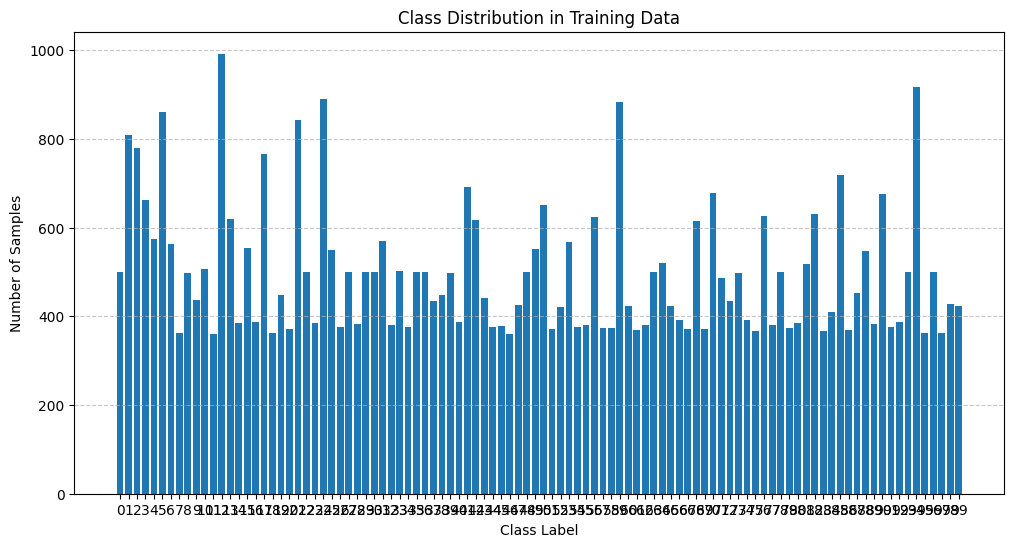

In [ ]:
class_counts = annotations['label_idx'].value_counts().sort_index()

# Plot class distribution
plt.figure(figsize=(12, 6))
plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Class Label')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Training Data')
plt.xticks(range(len(class_counts)))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## ResNet50

In [ ]:
annotations_path = "/content/data/task2/train_data/annotations.csv"
labeled_images_path = "/content/data/task2/train_data/images/labeled"
val_images_path = "/content/data/task2/val_data"

# Load annotations
annotations = pd.read_csv(annotations_path)
# Split into train and val
train_annotations, val_annotations = train_test_split(annotations, test_size=0.2, stratify=annotations['label_idx'], random_state=42)

print(f"Training samples: {len(train_annotations)}, Validation samples: {len(val_annotations)}")

print(train_annotations.head())

Training samples: 40000, Validation samples: 10000
                                     renamed_path  label_idx
31138  task2/train_data/images/labeled/31138.jpeg         81
6179    task2/train_data/images/labeled/6179.jpeg         15
8995    task2/train_data/images/labeled/8995.jpeg         23
36262  task2/train_data/images/labeled/36262.jpeg         94
19536  task2/train_data/images/labeled/19536.jpeg         50


In [ ]:
class NoisyLabelsDataset(Dataset):
    def __init__(self, annotations, image_dir, transform=None):
        self.annotations = annotations
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_name = self.annotations.iloc[idx, 0]
        label = self.annotations.iloc[idx, 1]
        img_path = os.path.join(self.image_dir, img_name)

        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        return image, label


# Define transforms
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


train_dataset = NoisyLabelsDataset(train_annotations, "/content/data", transform=train_transform)
val_dataset = NoisyLabelsDataset(val_annotations, "/content/data", transform=val_transform)

# Create DataLoaders
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Training batches: {len(train_loader)}, Validation batches: {len(val_loader)}")


Training batches: 1250, Validation batches: 313


In [ ]:
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        scheduler.step()

        train_acc = 100.0 * correct / total
        train_loss = running_loss / len(train_loader.dataset)
        val_acc, val_loss = validate_model(model, val_loader, criterion)

        # Save the model
        model_path = f"model_epoch_{epoch+1}.pth"
        torch.save(model.state_dict(), model_path)
        print(f"Model saved at {model_path}")

        print(f"Epoch [{epoch+1}/{num_epochs}], "
                      f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
                      f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
# Validation function
def validate_model(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_acc = 100.0 * correct / total
    val_loss /= len(val_loader.dataset)
    return val_acc, val_loss

In [ ]:
model = models.resnet50(weights="DEFAULT")
num_classes = len(annotations['label_idx'].unique())
model.fc = nn.Linear(model.fc.in_features, num_classes)
print(num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss function
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  # Add label smoothing

# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
num_epochs = 15
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs)


100
Model saved at model_epoch_1.pth
Epoch [1/15], Train Loss: 3.1415, Train Acc: 32.09%, Val Loss: 2.0315, Val Acc: 59.53%
Model saved at model_epoch_2.pth
Epoch [2/15], Train Loss: 2.4828, Train Acc: 47.42%, Val Loss: 1.9042, Val Acc: 63.33%
Model saved at model_epoch_3.pth
Epoch [3/15], Train Loss: 2.3146, Train Acc: 52.13%, Val Loss: 1.8511, Val Acc: 63.80%
Model saved at model_epoch_4.pth
Epoch [4/15], Train Loss: 2.2086, Train Acc: 54.51%, Val Loss: 1.8415, Val Acc: 64.47%
Model saved at model_epoch_5.pth
Epoch [5/15], Train Loss: 2.1272, Train Acc: 56.95%, Val Loss: 1.8091, Val Acc: 64.20%
Model saved at model_epoch_6.pth
Epoch [6/15], Train Loss: 2.0441, Train Acc: 59.07%, Val Loss: 1.7966, Val Acc: 65.05%
Model saved at model_epoch_7.pth
Epoch [7/15], Train Loss: 1.9763, Train Acc: 60.98%, Val Loss: 1.7750, Val Acc: 65.85%
Model saved at model_epoch_8.pth
Epoch [8/15], Train Loss: 1.9086, Train Acc: 62.81%, Val Loss: 1.7649, Val Acc: 65.78%
Model saved at model_epoch_9.pth
Epo

In [ ]:
class UnlabeledDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.images = sorted(os.listdir(image_dir))
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)

        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        return image, img_name

val_dir = "/content/data/task2/val_data"

# Create the validation dataset and DataLoader
test_dataset = UnlabeledDataset(val_dir, transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


model.eval()

# List to store predictions
predictions = []

# Inference loop
with torch.no_grad():
    for images, img_names in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)  # Get the index of the max log-probability

        # Append predictions with image names
        for img_name, label in zip(img_names, predicted.cpu().numpy()):
            predictions.append({
                "ID": f"task2/val_data/{img_name}",
                "label": label
            })

# Convert predictions to a DataFrame
submission_df = pd.DataFrame(predictions)

# Save to CSV
submission_file = "submission.csv"
submission_df.to_csv(submission_file, index=False)

print(f"Submission file saved as {submission_file}")

NameError: name 'val_transform' is not defined

## DivideMix

In [ ]:
class LabeledDataset(Dataset):
    def __init__(self, annotations, image_dir, transform=None):
        self.annotations = annotations
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_name = self.annotations.iloc[idx, 0]
        label = self.annotations.iloc[idx, 1]
        img_path = os.path.join(self.image_dir, img_name)

        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        return image, label

class UnlabeledDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.images = sorted(os.listdir(image_dir))
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)

        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        return image

class TestDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.images = sorted(os.listdir(image_dir))
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)

        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        return image, img_name

class CustomDataset(Dataset):
    def __init__(self, annotations, image_dir, mode, transform=None, pred=None, prob=None):
        self.annotations = annotations
        self.image_dir = image_dir
        self.mode = mode
        self.transform = transform
        self.pred = pred
        self.prob = prob

        if pred is not None:
            pred = np.array(pred, dtype=bool)  # Ensure `pred` is a numpy array of boolean values
        if prob is not None:
            prob = np.array(prob)  # Ensure `prob` is a numpy array

        if mode == 'all':
            self.data = self.annotations
        elif mode == 'labeled':
            # Filter clean samples based on `pred`
            self.data = self.annotations[pred].reset_index(drop=True)
            self.prob = prob[pred]
        elif mode == 'unlabeled':
            # Filter noisy samples
            self.data = self.annotations[~pred].reset_index(drop=True)
            self.prob = prob[~pred]
        elif mode in ['test', 'val']:
            self.data = self.annotations

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx, 0]
        label = self.data.iloc[idx, 1] if self.mode in ['labeled', 'all'] else None
        img_path = os.path.join(self.image_dir, img_name)

        image = Image.open(img_path).convert('RGB')

        if self.transform:
            img1 = self.transform(image)
            img2 = self.transform(image)  # Create duplicate transformations

        if self.mode == 'labeled':
            prob = self.prob[idx]
            return img1, img2, label, prob
        elif self.mode == 'unlabeled':
            return img1, img2
        elif self.mode == 'all':
            return img1, label
        elif self.mode in ['test', 'val']:
            return img1, label

class CustomDataloader:
    def __init__(self, batch_size, num_workers):
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.transform_train = transforms.Compose([
                transforms.Resize(256),
                transforms.RandomCrop(224),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize((0.6959, 0.6537, 0.6371),(0.3113, 0.3192, 0.3214)),
            ])
        self.transform_test = transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize((0.6959, 0.6537, 0.6371),(0.3113, 0.3192, 0.3214)),
            ])
        self.annotations = annotations

    def run(self, mode, annotations, pred=[],prob=[]):
      if mode == 'warmup':
            dataset = CustomDataset(annotations, "/content/data", mode='all', transform=self.transform_train)
            loader = DataLoader(dataset, batch_size=self.batch_size * 2, shuffle=True, num_workers=self.num_workers)
            return loader
      elif mode == 'train':
        labeled_dataset = CustomDataset(
                annotations, "/content/data", mode='labeled',
                transform=self.transform_train, pred=pred, prob=prob
            )
        unlabeled_dataset = CustomDataset(
                annotations, "/content/data", mode='unlabeled',
                transform=self.transform_train, pred=pred, prob=prob
            )
        labeled_loader = DataLoader(labeled_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)
        unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)
        return labeled_loader, unlabeled_loader

      elif mode == 'eval_train':
            eval_dataset = LabeledDataset(
                annotations=annotations,
                image_dir="/content/data",
                transform=self.transform_test,
            )
            eval_loader = DataLoader(
                dataset=eval_dataset,
                batch_size=self.batch_size,
                shuffle=False,
                num_workers=self.num_workers,
            )
            return eval_loader

      elif mode == 'val':
            val_dataset = LabeledDataset(
                annotations=annotations,
                image_dir="/content/data",
                transform=self.transform_test
            )

            val_loader = DataLoader(
                dataset=val_dataset,
                batch_size=self.batch_size,
                shuffle=False,
                num_workers=self.num_workers
            )
            return val_loader

      elif mode == 'test':
            test_dataset = TestDataset(
                image_dir="/content/data/task2/val_data",  # Assuming test images are in the unlabeled path
                transform=self.transform_test,
            )

            test_loader = DataLoader(
                dataset=test_dataset,
                batch_size=self.batch_size,
                shuffle=False,
                num_workers=self.num_workers,
            )
            return test_loader


annotations_path = "/content/data/task2/train_data/annotations.csv"
labeled_images_path = "/content/data/task2/train_data/images/labeled"
val_images_path = "/content/data/task2/val_data"

# Load annotations
annotations = pd.read_csv(annotations_path)
# Split into train and val
train_annotations, val_annotations = train_test_split(annotations, test_size=0.2, stratify=annotations['label_idx'], random_state=42)

# Initialize the custom data loader
custom_loader = CustomDataloader(
    batch_size=32,
    num_workers=4,
)


# Warm-up phase
warmup_loader = custom_loader.run('warmup', annotations=train_annotations)

num_classes = len(annotations['label_idx'].unique())
print(num_classes)

100


In [ ]:
def create_model():
    model = models.resnet50(weights="DEFAULT")
    model.fc = nn.Linear(2048,num_classes)
    model = model.cuda()
    return model

class NegEntropy(object):
    def __call__(self,outputs):
        probs = torch.softmax(outputs, dim=1)
        return torch.mean(torch.sum(probs.log()*probs, dim=1))

def warmup(net,optimizer,dataloader):
    net.train()
    running_loss = 0.0  # Initialize running loss

    for batch_idx, (inputs, labels) in enumerate(dataloader):
        inputs, labels = inputs.cuda(), labels.cuda()
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = CEloss(outputs, labels)

        penalty = conf_penalty(outputs)
        total_loss = loss + penalty      # Combine loss and penalty
        total_loss.backward()            # Backpropagation
        optimizer.step()

        running_loss += total_loss.item()  # Accumulate total loss

        sys.stdout.write('\r')
        sys.stdout.write('|Warm-up: Iter[%3d/%3d]\t CE-loss: %.4f  Conf-Penalty: %.4f'
                %(batch_idx+1, len(dataloader), loss.item(), penalty.item()))
        sys.stdout.flush()

    print(f"\nWarm-up completed. Average Loss: {running_loss / len(dataloader):.4f}")

def eval_train(model):
    model.eval()
    losses = []

    with torch.no_grad():
      for batch_idx, (inputs, targets) in enumerate(eval_loader):  # No `path` here
          inputs, targets = inputs.cuda(), targets.cuda()
          outputs = model(inputs)
          loss = CE(outputs, targets)  # Per-sample loss
          losses.extend(loss.cpu().numpy())  # Store losses

          sys.stdout.write('\r')
          sys.stdout.write('| Evaluating loss Iter [%3d/%3d]\t'
                            % (batch_idx + 1, len(eval_loader)))
          sys.stdout.flush()

    losses = np.array(losses)
    # Normalize losses
    losses = (losses - losses.min()) / (losses.max() - losses.min())
    losses = losses.reshape(-1, 1)

    gmm = GaussianMixture(n_components=2, max_iter=10, reg_covar=5e-4, tol=1e-2)
    gmm.fit(losses)
    prob = gmm.predict_proba(losses)  # Probabilities for each component
    prob = prob[:, gmm.means_.argmin()]  # Probability of being clean

    return prob

def train(epoch, net, net2, optimizer, labeled_trainloader, unlabeled_trainloader, num_classes, temperature, alpha):
    net.train()
    net2.eval()  # Fix one network and train the other

    unlabeled_train_iter = iter(unlabeled_trainloader)
    num_iter = len(labeled_trainloader)

    for batch_idx, (inputs_x, inputs_x2, labels_x, w_x) in enumerate(labeled_trainloader):
        try:
            inputs_u, inputs_u2 = next(unlabeled_train_iter)
        except StopIteration:
            unlabeled_train_iter = iter(unlabeled_trainloader)
            inputs_u, inputs_u2 = next(unlabeled_train_iter)

        batch_size = inputs_x.size(0)

        # Transform labels to one-hot encoding
        labels_x = torch.zeros(batch_size, num_classes).scatter_(1, labels_x.view(-1, 1), 1)
        w_x = w_x.view(-1, 1).float()

         # Move to GPU
        inputs_x, inputs_x2, labels_x, w_x = inputs_x.cuda(), inputs_x2.cuda(), labels_x.cuda(), w_x.cuda()
        inputs_u, inputs_u2 = inputs_u.cuda(), inputs_u2.cuda()

        with torch.no_grad():
            # Co-guessing on unlabeled samples
            outputs_u11 = net(inputs_u)
            outputs_u12 = net(inputs_u2)
            outputs_u21 = net2(inputs_u)
            outputs_u22 = net2(inputs_u2)

            pu = (torch.softmax(outputs_u11, dim=1) + torch.softmax(outputs_u12, dim=1) +
                  torch.softmax(outputs_u21, dim=1) + torch.softmax(outputs_u22, dim=1)) / 4
            ptu = pu**(1 / temperature)  # Temperature sharpening
            targets_u = (ptu / ptu.sum(dim=1, keepdim=True)).detach()  # Normalize

            # Refinement on labeled samples
            outputs_x = net(inputs_x)
            outputs_x2 = net(inputs_x2)

            px = (torch.softmax(outputs_x, dim=1) + torch.softmax(outputs_x2, dim=1)) / 2
            px = w_x * labels_x + (1 - w_x) * px
            ptx = px**(1 / temperature)  # Temperature sharpening
            targets_x = (ptx / ptx.sum(dim=1, keepdim=True)).detach()

        # MixMatch (Mix inputs and targets)
        l = np.random.beta(alpha, alpha)
        l = max(l, 1 - l)

        all_inputs = torch.cat([inputs_x, inputs_x2, inputs_u, inputs_u2], dim=0)
        all_targets = torch.cat([targets_x, targets_x, targets_u, targets_u], dim=0)

        idx = torch.randperm(all_inputs.size(0))
        input_a, input_b = all_inputs, all_inputs[idx]
        target_a, target_b = all_targets, all_targets[idx]

        mixed_input = l * input_a[:batch_size * 2] + (1 - l) * input_b[:batch_size * 2]
        mixed_target = l * target_a[:batch_size * 2] + (1 - l) * target_b[:batch_size * 2]

        # Forward pass
        logits = net(mixed_input)
        Lx = -torch.mean(torch.sum(F.log_softmax(logits, dim=1) * mixed_target, dim=1))

        # Regularization
        prior = torch.ones(num_classes) / num_classes
        prior = prior.cuda()
        pred_mean = torch.softmax(logits, dim=1).mean(0)
        penalty = torch.sum(prior * torch.log(prior / pred_mean))

        loss = Lx + penalty

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Logging
        sys.stdout.write('\r')
        sys.stdout.write(f'Epoch [{epoch}] Iter[{batch_idx + 1}/{num_iter}] Labeled loss: {Lx.item():.4f}')
        sys.stdout.flush()


# Define a simple validation function
def validate(epoch, net1, net2, val_loader):
    net1.eval()
    net2.eval()
    total_correct_net1, total_correct_net2 = 0, 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.cuda(), labels.cuda()

            # Net1 predictions
            outputs_net1 = net1(inputs)
            _, predicted_net1 = outputs_net1.max(1)
            total_correct_net1 += (predicted_net1 == labels).sum().item()

            # Net2 predictions
            outputs_net2 = net2(inputs)
            _, predicted_net2 = outputs_net2.max(1)
            total_correct_net2 += (predicted_net2 == labels).sum().item()

            total_samples += labels.size(0)

    acc_net1 = 100.0 * total_correct_net1 / total_samples
    acc_net2 = 100.0 * total_correct_net2 / total_samples

    print(f"Epoch [{epoch}] Validation Accuracy - Net1: {acc_net1:.2f}%, Net2: {acc_net2:.2f}%")
    return acc_net1, acc_net2


In [ ]:
print('| Building net')
net1 = create_model()
net2 = create_model()

optimizer1 = optim.SGD(net1.parameters(), lr=0.002, momentum=0.9, weight_decay=1e-3)
optimizer2 = optim.SGD(net2.parameters(), lr=0.002, momentum=0.9, weight_decay=1e-3)


CE = nn.CrossEntropyLoss(reduction='none')
CEloss = nn.CrossEntropyLoss()
conf_penalty = NegEntropy()

best_acc_net1 = 0
best_acc_net2 = 0

for epoch in range(10 + 1):
  if epoch < 1:  # Warm-up phase
        train_loader = custom_loader.run('warmup', annotations=train_annotations)
        print('Warmup Net1')
        warmup(net1, optimizer1, train_loader)
        train_loader = custom_loader.run('warmup', annotations=train_annotations)
        print('\nWarmup Net2')
        warmup(net2, optimizer2, train_loader)
  else:
      print('\n==== Evaluate Loss for Net1 ====')
      eval_loader = custom_loader.run('eval_train', annotations=train_annotations)
      prob1 = eval_train(net1)

      print('\n==== Evaluate Loss for Net2 ====')
      eval_loader = custom_loader.run('eval_train', annotations=train_annotations)
      prob2 = eval_train(net2)

      pred1 = (prob1 > 0.5)  # Threshold for clean samples for Net1
      pred2 = (prob2 > 0.5)  # Threshold for clean samples for Net2
      print('\n\nTrain Net1')
      labeled_trainloader, unlabeled_trainloader = custom_loader.run('train', annotations=train_annotations, pred=pred2, prob=prob2)  # Co-divide
      train(epoch, net1, net2, optimizer1, labeled_trainloader, unlabeled_trainloader, num_classes, temperature=0.5, alpha=0.5)

      print('\nTrain Net2')
      labeled_trainloader, unlabeled_trainloader = custom_loader.run('train', annotations=train_annotations, pred=pred1, prob=prob1)  # Co-divide
      train(epoch, net2, net1, optimizer2, labeled_trainloader, unlabeled_trainloader, num_classes, temperature=0.5, alpha=0.5)

  # Validation phase
  print('\n==== Validation Phase ====')
  val_loader = custom_loader.run('val', annotations=val_annotations)
  acc_net1, acc_net2 = validate(epoch, net1, net2, val_loader)

  # Save best models based on validation accuracy
  if acc_net1 > best_acc_net1:
      best_acc_net1 = acc_net1
      torch.save(net1.state_dict(), f'best_net1_epoch_{epoch}.pth')

  if acc_net2 > best_acc_net2:
      best_acc_net2 = acc_net2
      torch.save(net2.state_dict(), f'best_net2_epoch_{epoch}.pth')

| Building net
Warmup Net1
|Warm-up: Iter[625/625]	 CE-loss: 2.3909  Conf-Penalty: -4.0738
Warm-up completed. Average Loss: -0.9977

Warmup Net2
|Warm-up: Iter[625/625]	 CE-loss: 2.4654  Conf-Penalty: -4.0707
Warm-up completed. Average Loss: -0.9605

==== Validation Phase ====
Epoch [0] Validation Accuracy - Net1: 62.63%, Net2: 61.45%

==== Evaluate Loss for Net1 ====
| Evaluating loss Iter [1250/1250]	
==== Evaluate Loss for Net2 ====
| Evaluating loss Iter [1250/1250]	

Train Net1
Epoch [1] Iter[805/805] Labeled loss: 3.3000
Train Net2
Epoch [1] Iter[818/818] Labeled loss: 1.7829
==== Validation Phase ====
Epoch [1] Validation Accuracy - Net1: 64.65%, Net2: 65.12%

==== Evaluate Loss for Net1 ====
| Evaluating loss Iter [1250/1250]	
==== Evaluate Loss for Net2 ====
| Evaluating loss Iter [1250/1250]	

Train Net1
Epoch [2] Iter[833/833] Labeled loss: 1.3673
Train Net2
Epoch [2] Iter[900/900] Labeled loss: 3.4605
==== Validation Phase ====
Epoch [2] Validation Accuracy - Net1: 67.14%, 

In [ ]:
class UnlabeledDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.images = sorted(os.listdir(image_dir))
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)

        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        return image, img_name

val_dir = "/content/data/task2/val_data"

transform_test = transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize((0.6959, 0.6537, 0.6371),(0.3113, 0.3192, 0.3214)),
            ])

# Create the validation dataset and DataLoader
test_dataset = UnlabeledDataset(val_dir, transform=transform_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

net1.load_state_dict(torch.load('best_net1_epoch_8.pth'))
net2.load_state_dict(torch.load('best_net2_epoch_10.pth'))

net1.eval()
net2.eval()

# List to store predictions
predictions = []

# Inference loop
with torch.no_grad():
    for images, img_names in test_loader:
        images = images.to(device)

        # Predictions from both networks
        outputs_net1 = net1(images)
        outputs_net2 = net2(images)

        # Softmax to get probabilities
        probs_net1 = torch.softmax(outputs_net1, dim=1)
        probs_net2 = torch.softmax(outputs_net2, dim=1)

        # Combine predictions (e.g., average probabilities)
        combined_probs = (probs_net1 + probs_net2) / 2

        # Final predictions (get class with highest probability)
        _, predicted_classes = combined_probs.max(1)

        # Append predictions with image names
        for img_name, label in zip(img_names, predicted_classes.cpu().numpy()):
            predictions.append({
                "ID": f"task2/val_data/{img_name}",
                "label": label
            })


# Convert predictions to a DataFrame
submission_df = pd.DataFrame(predictions)

# Save to CSV
submission_file = "submission.csv"
submission_df.to_csv(submission_file, index=False)

print(f"Submission file saved as {submission_file}")

<ipython-input-13-3a2a2486699b>:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net1.load_state_dict(torch.load('best_net1_epoch_8.pth'))
<ipython-input-13-3a2a2486699b>:3

Submission file saved as submission.csv
